<a href="https://colab.research.google.com/github/subrapak/Image-Classification-Using-Keras/blob/master/vgg16_for_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine tuning the VGG16 model to classify images from the CIFAR-10 dataset

The following notebook is an attempt to classify the CIFAR-10 dataset using a fine tuned version of the pre-existing VGG16 deep convolutional network.

Initially, the code was run locally on a 13-inch Late 2011 MacBook Pro with a 2.4GHz Intel Core i5 processor. Unfortunately, as the training was too slow, the code was stripped down and transferred into the Google Colab workspace, and was run using a cloud GPU, specifications for which are given below.

Despite the added computing power, the were still limitations on the batch size and number of images that the GPU could handle and as such, the accuracy achieved could be improved by training the network on larger batches with more variability in images.

**An accuracy of just over 70% was achieved using 3000 sample images, a batch size of 64 and 40 epochs. The SGD and Adam optimizer was used with a progressively smaller learning rates, with categorical cross entropy as the loss function.**

This first piece of code shows us the GPU or CPU that we're currently using with Google Colab:

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7944220852210386541, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8546170618818096215
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1876564314333632402
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11228868237838419931
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

Import all the relevant dependencies:

In [2]:
import numpy as np
import scipy
from scipy.sparse import hstack
import pandas as pd
import itertools
import cv2
from matplotlib import pyplot as plt
%matplotlib inline


import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, SGD, Nadam, Adagrad
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
#from keras.layers.normalization import BatchNormalization
#from keras.layers.convolutional import *


from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


Using TensorFlow backend.


# Acquire and load CIFAR-10 dataset

First, we need to acquire the CIFAR-10 dataset from the CIFAR website: [CIFAR datasets](https://www.cs.toronto.edu/~kriz/cifar.html)

Download the Python version of the dataset, and save it locally on a device, and then extract/unzip the file until you have a folder named 'cifar-10-batches-py' - this contains the training and test data sets.

Next, we upload the relevant files (one training dataset and the test dataset) to the Google Colab workspace, and from there we can load it into our notebook, as shown below.

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
#code only needs to be run once - after this, it can be commented out
from google.colab import files
uploaded = files.upload()

Saving data_batch_1 to data_batch_1
Saving test_batch to test_batch


In [0]:
#create two new dicts
raw_trainvalid = unpickle('data_batch_1')
raw_test = unpickle('test_batch')

In [0]:
df_raw_trainvalid = pd.DataFrame()
df_raw_trainvalid = df_raw_trainvalid.from_dict(raw_trainvalid,orient='index')

#training and validation samples
trainval_samps = np.array(df_raw_trainvalid[0][2])
#training and validation labels
trainval_labs = np.array(df_raw_trainvalid[0][1])
trainval_labs = trainval_labs.reshape(len(trainval_labs),1)


df_raw_test = pd.DataFrame()
df_raw_test = df_raw_test.from_dict(raw_test,orient='index')

#test samples
test_samps = np.array(df_raw_test[0][2])
#test labels
test_labs = np.array(df_raw_test[0][1])
test_labs = test_labs.reshape(len(test_labs),1)

Convert the image labels (which are currently numeric) into one hot encoded vectors:

In [0]:
enc = OneHotEncoder()

trainval_labs_cls = enc.fit_transform(trainval_labs)
trainval_labs_cls = hstack([trainval_labs_cls]).toarray() #use hstack to convert the vectors into arrays for processing later on

test_labs_cls = enc.fit_transform(test_labs)
test_labs_cls = hstack([test_labs_cls]).toarray()


Each array contains 10,000 images - AKA 10000 arrays of 3072 numbers each, with each number representing one pixel in an RGB image of 32x32 pixels. There are 3072 values because each image has 32x32 pixels, and has three layers (RGB) so 32x32x3 = 3072.

We need to reshape these integer arrays so they're in the shape 32x32x3. Once resized, we have to changed the orientation of the array using the img.transpose() function, so that the images can be displayed using the plt.imshow() function later on.

In [0]:
trainval_samp_imgs = np.reshape(trainval_samps,[len(trainval_samps),3,32,32])
trainval_samp_imgs = trainval_samp_imgs.transpose((0,2,3,1))

test_samp_imgs = np.reshape(test_samps,[len(test_samps),3,32,32])
test_samp_imgs = test_samp_imgs.transpose((0,2,3,1))

The VGG16 neural net that we use later on only accepts images in the size 224x224 pixels - for this we need to resize the images; do this below:

In [0]:
#Expect a pause

sized_trainval_samp_imgs = []
sized_test_samp_imgs = []

for i in range(len(trainval_samp_imgs)):
    sized_trainval_samp_imgs.append(cv2.resize(trainval_samp_imgs[i], dsize=(224, 224)))
    sized_test_samp_imgs.append(cv2.resize(test_samp_imgs[i], dsize=(224, 224)))


sized_trainval_samp_imgs = np.array(sized_trainval_samp_imgs)
sized_test_samp_imgs = np.array(sized_test_samp_imgs)


So we found that if you resize the images and then try and make a training, validation and test set from 10,000 images that are 244x244x3, that will take way too long. So instead we've put in parameters for number of samples, batchsize and validation split so that the ImageDataGenerator can handle it.

In [12]:
val_split = 0.2 #fraction of images that become validation data (rest are training)
batchsize = 64 #set batchsize
n_samples = 3000 #set to 10,000 to use all trainval images - max test samples is also 10,000
#n_samples > 3000 ish gives memory problems. Increase the no. of epochs instead.

n_train = n_samples*(1-val_split) #number of training samples
n_valid = n_samples*(val_split) #number of validation samples


train_batches = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True, rescale=(1/255), validation_split=val_split).flow(x = sized_trainval_samp_imgs[0:n_samples], y = trainval_labs_cls[0:n_samples], batch_size = batchsize,shuffle=True,subset="training")
print('traindone')
valid_batches = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True, rescale=(1/255), validation_split=val_split).flow(x = sized_trainval_samp_imgs[0:n_samples], y = trainval_labs_cls[0:n_samples], batch_size = batchsize,shuffle=True,subset="validation")
print('validdone')
test_batches = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True, rescale=(1/255)).flow(x = sized_test_samp_imgs[0:n_samples], y = test_labs_cls[0:n_samples], batch_size = batchsize, shuffle=True)
print('testdone')


traindone
validdone
testdone


 # Plotting images


This section is just there to check that the images have been resized, and to see the comparison between a 32x32 image and a 224x224 image:

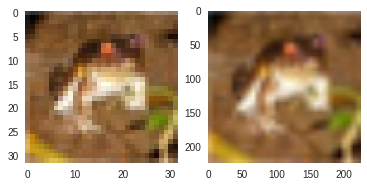

In [13]:

plt.subplot(1,2,1)
plt.imshow(trainval_samp_imgs[0])
plt.grid('off')
plt.subplot(1,2,2)
plt.imshow(sized_trainval_samp_imgs[0])
plt.grid('off')

# Build Fine Tuned VGG16 model

First, we import the VGG16 model, which comes within the keras package. After this, we create a new model named `model`, to which we add each layer of the VGG16 model except the final one. As the VGG16 model can classify images in upto 1000 categories, its final layer is a dense layer with 1000 nodes. As we only require 10 classifications, we remove the bottom layer and add in a dense layer with 10 nodes.

As the rest of the model is well trained, we only train the last layer - this also massively reduces the time required for training.

In [14]:
vgg16_model = keras.applications.vgg16.VGG16()


553467904/553467096 [==============================] - 37s 0us/step


In [15]:
type(vgg16_model)
vgg16_model.summary()

keras.engine.training.Model

With the VGG16 model, as it classifies images into 1000 different classes, this is too many - we only require classification into 10 different classes. Therefore, in the final Dense layer, instead of an output vector of 1000, we need an output vector of just 10.

To do this, we create a new sequential model called 'model' using `model = Sequential()` and add all but the last VGG16 layers to it. Then, we make all these layers untrainable (as they have already been trained and their weights do not need to be updated), and add a final dense layer with 10 outputs and a softmax activation function.

The softmax activation function ensures that all the output values in the final array sum to 1 (essentially giving us the probability that the network thinks the image belongs to each of those categories). We can see the completed model in the final `model.summary()` cell.

In [0]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [0]:
for layer in model.layers:
    layer.trainable = False #excluding each layer from future training, useful for fine tuning

In [0]:
model.add(Dense(10, activation = 'softmax'))

In [19]:
#see final model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

# Train Fine Tuned VGG16 model

Finally, we train the model. Based on the research paper, we have standardized our input data (see `ImageDataGenerator()` cell) and are choosing to use a stochastic gradient descent optimizer with a learning rate of 0.01 and momentum of 0.9, also in accordance with the paper.

A number of trials showed that the best optimizer to use for the next section was Adam, and it is used for the next two sets of 20 epochs with a progressively smaller learning rate. This achieves an consistent accuracy of over 70%.

In [20]:
model.compile(SGD(lr=0.01, momentum = 0.9), loss = "categorical_crossentropy", metrics=["accuracy"])
model.fit_generator(train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, validation_steps=len(valid_batches), epochs=20, verbose=1)


Epoch 1/20
38/38 [==============================] - 38s 1s/step - loss: 2.2778 - acc: 0.2142 - val_loss: 2.1576 - val_acc: 0.3567
Epoch 2/20
38/38 [==============================] - 25s 670ms/step - loss: 1.8012 - acc: 0.4054 - val_loss: 1.6411 - val_acc: 0.4483
Epoch 3/20
38/38 [==============================] - 25s 671ms/step - loss: 1.5925 - acc: 0.4535 - val_loss: 1.2291 - val_acc: 0.5867
Epoch 4/20
38/38 [==============================] - 25s 671ms/step - loss: 1.4100 - acc: 0.5230 - val_loss: 1.2775 - val_acc: 0.5700
Epoch 5/20
38/38 [==============================] - 25s 671ms/step - loss: 1.2186 - acc: 0.5708 - val_loss: 1.4312 - val_acc: 0.4850
Epoch 6/20
38/38 [==============================] - 25s 671ms/step - loss: 1.2497 - acc: 0.5592 - val_loss: 1.3740 - val_acc: 0.5050
Epoch 7/20
38/38 [==============================] - 25s 668ms/step - loss: 1.2682 - acc: 0.5732 - val_loss: 1.3909 - val_acc: 0.5300
Epoch 8/20
38/38 [==============================] - 25s 670ms/step - los

In [21]:
model.compile(Adam(lr=0.005), loss = "categorical_crossentropy", metrics=["accuracy"])
model.fit_generator(train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, validation_steps=len(valid_batches), epochs=20, verbose=1)

Epoch 1/20
38/38 [==============================] - 26s 688ms/step - loss: 0.8645 - acc: 0.7040 - val_loss: 0.9085 - val_acc: 0.6717
Epoch 2/20
38/38 [==============================] - 26s 671ms/step - loss: 0.7973 - acc: 0.7340 - val_loss: 0.9580 - val_acc: 0.6667
Epoch 3/20
38/38 [==============================] - 25s 671ms/step - loss: 0.8160 - acc: 0.7163 - val_loss: 0.9010 - val_acc: 0.6983
Epoch 4/20
38/38 [==============================] - 26s 672ms/step - loss: 0.7715 - acc: 0.7471 - val_loss: 0.8884 - val_acc: 0.6950
Epoch 5/20
38/38 [==============================] - 25s 671ms/step - loss: 0.7962 - acc: 0.7303 - val_loss: 0.9059 - val_acc: 0.6767
Epoch 6/20
38/38 [==============================] - 25s 670ms/step - loss: 0.7686 - acc: 0.7352 - val_loss: 0.9012 - val_acc: 0.6950
Epoch 7/20
38/38 [==============================] - 25s 670ms/step - loss: 0.7622 - acc: 0.7484 - val_loss: 0.8750 - val_acc: 0.7017
Epoch 8/20
38/38 [==============================] - 25s 670ms/step - 

In [22]:
model.compile(Adam(lr=0.0005), loss = "categorical_crossentropy", metrics=["accuracy"])
model.fit_generator(train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, validation_steps=len(valid_batches), epochs=20, verbose=1)

Epoch 1/20
38/38 [==============================] - 26s 687ms/step - loss: 0.6985 - acc: 0.7681 - val_loss: 0.8203 - val_acc: 0.7267
Epoch 2/20
38/38 [==============================] - 25s 669ms/step - loss: 0.6830 - acc: 0.7722 - val_loss: 0.8244 - val_acc: 0.7167
Epoch 3/20
38/38 [==============================] - 25s 670ms/step - loss: 0.6896 - acc: 0.7702 - val_loss: 0.8710 - val_acc: 0.7100
Epoch 4/20
38/38 [==============================] - 26s 672ms/step - loss: 0.6656 - acc: 0.7825 - val_loss: 0.9058 - val_acc: 0.7000
Epoch 5/20
38/38 [==============================] - 26s 672ms/step - loss: 0.6729 - acc: 0.7710 - val_loss: 0.8366 - val_acc: 0.7300
Epoch 6/20
38/38 [==============================] - 25s 671ms/step - loss: 0.6641 - acc: 0.7771 - val_loss: 0.8196 - val_acc: 0.7167
Epoch 7/20
38/38 [==============================] - 25s 671ms/step - loss: 0.6568 - acc: 0.7894 - val_loss: 0.8748 - val_acc: 0.7000
Epoch 8/20
38/38 [==============================] - 25s 669ms/step - 

# Discussion


The accuracy of the network could be improved by training more of the layers of the model as opposed to just the final layer - however, this would greatly increase the time taken for training. For example, training the penultimate layer as well would increase the number of weights to train from 40,970 to 16,822,282, which is a x410 increase!

In addition, the batch size could be increased to 256 like the original paper did, and the network could be trained on all five data batches provided by CIFAR (as opposed to the singular one used here). However, there is not enough memory in the current GPU provided by Google Colab to allow for these many images, so the program is limited by hardware constraints.

An alternative approach would be to not resize the CIFAR images - by keeping them 32x32 pixels, each image takes up much less memory to process, and therefore more images can be used. This would require us to remove the top two layers of the VGG16 model [`block1_conv1 (Conv2D)`,  `block1_conv2 (Conv2D)`]  and add our own layers that accepted an input shape of (32, 32, 3), and would also have to be trained, which would add to training time.